In [4]:
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_groq import ChatGroq
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool



loading the pdf and the embedding model

In [9]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
loader = PyPDFLoader("Unit 3 Optoelectronic Properties of Semiconductors.pdf")
docs = loader.load()

checking for the laoded pdf

In [10]:
len(docs)

73

splitting the document 

In [11]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=64 
)
chunks=splitter.split_documents(docs)


checking the split

In [12]:
print(chunks)

[Document(metadata={'producer': 'Microsoft® Office PowerPoint® 2007', 'creator': 'Microsoft® Office PowerPoint® 2007', 'creationdate': '2023-03-27T10:20:18+05:30', 'title': 'PowerPoint Presentation', 'author': 'ganesh vattikondala', 'moddate': '2023-03-27T10:20:18+05:30', 'source': 'Unit 3 Optoelectronic Properties of Semiconductors.pdf', 'total_pages': 73, 'page': 0, 'page_label': '1'}, page_content='Semiconductor Physics and \nComputational Methods \n(21PYB102J) \n \nCourse Instructor: Dr. Venkata Ravindra A \n         Assistant Professor \n         Department of Physics and Nanotechnology \n         SRM Institute of Science and Technology \n         Email: venkatar1@srmist.edu.in \n         Phone: 8019448666 \n         Office: UB-709/A 27 March 2023 1'), Document(metadata={'producer': 'Microsoft® Office PowerPoint® 2007', 'creator': 'Microsoft® Office PowerPoint® 2007', 'creationdate': '2023-03-27T10:20:18+05:30', 'title': 'PowerPoint Presentation', 'author': 'ganesh vattikondala', 

creating the vector database

In [13]:
vectorDB = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
    persist_directory="./chromadb"
)
retriever = vectorDB.as_retriever()

checking the vector db

In [ ]:
check = retriever.invoke("Absorption")
print(check)

[Document(id='9b41f948-574d-4efc-b3de-cc22d5aa0ba0', metadata={'producer': 'Microsoft® Office PowerPoint® 2007', 'source': 'Unit 3 Optoelectronic Properties of Semiconductors.pdf', 'author': 'ganesh vattikondala', 'total_pages': 73, 'page': 13, 'creator': 'Microsoft® Office PowerPoint® 2007', 'creationdate': '2023-03-27T10:20:18+05:30', 'moddate': '2023-03-27T10:20:18+05:30', 'title': 'PowerPoint Presentation', 'page_label': '14'}, page_content='Overall picture of Absorption and emission processes \n1\n4'), Document(id='dc2b8416-75d1-4fa7-9463-8328a4b139fb', metadata={'source': 'Unit 3 Optoelectronic Properties of Semiconductors.pdf', 'creationdate': '2023-03-27T10:20:18+05:30', 'producer': 'Microsoft® Office PowerPoint® 2007', 'page': 7, 'page_label': '8', 'total_pages': 73, 'moddate': '2023-03-27T10:20:18+05:30', 'creator': 'Microsoft® Office PowerPoint® 2007', 'author': 'ganesh vattikondala', 'title': 'PowerPoint Presentation'}, page_content='Absorption: \n\uf0d8Let us consider two 

C:\Users\lenovo\AppData\Local\Temp\ipykernel_26544\1329672593.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  check = retriever.get_relevant_documents("Absorption")


tools making

tool 1 

In [17]:
@tool 
def search(query:str)->str:
    """   This tool searches and returns the information from the Unit 3 Optoelectronic Properties of Semiconductors pdf """
    docs = retriever.invoke(query)
    if not docs:
        return "content not found in the document submitted"
    result=[]
    for i ,docs in enumerate(docs):
        result.append(f"document{i+1} : \n{docs.page_content}")
    return "\n\n".join(result)    


initiate the chatgroq

In [ ]:
tools=[search]
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0).bind_tools(tools=tools)


In [22]:
from langgraph.graph.message import add_messages


In [23]:
class AgenState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]

In [24]:
def should_continue(state:AgenState):
    """ checks if the tools is called in the last message"""
    results = state["messages"][-1]
    return hasattr(results,"tool_calls") and len(results.tool_calls)>0

In [31]:
Systemprompt = SystemMessage(
    content=""" You are an intelligent AI assistant who answers questions about unit 3 Optoelectrnoic  based on the PDF document loaded into your knowledge base.
Use the search tool available to answer questions about the question asked. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
""")
def ai(state:AgenState)->AgenState:
    """ this is to call the llm"""
    response = llm.invoke([Systemprompt] + state["messages"])
    return {"messages": [response]} 
   




In [32]:
tools_dict = {our_tool.name: our_tool for our_tool in tools}
def take_action(state: AgenState) -> AgenState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")
        
        if not t['name'] in tools_dict: 
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."
        
        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")
            

        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}


In [33]:
graph = StateGraph(AgenState)
graph.add_node("llm", ai)
graph.add_node("retriever_agent", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
)
graph.add_edge("retriever_agent", "llm")
graph.set_entry_point("llm")

rag_agent = graph.compile()

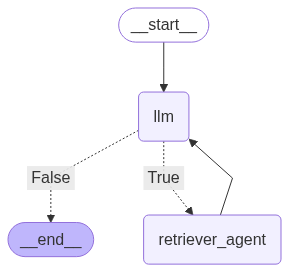

In [ ]:
from IPython.display import Image , display 
display(Image(rag_agent.get_graph().draw_mermaid_png()))

In [ ]:
def running_agent():
    print("\n=== RAG AGENT===")
    
    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ['exit', 'quit']:
            break
            
        messages = [HumanMessage(content=user_input)] 

        result = rag_agent.invoke({"messages": messages})
        
        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)


running_agent()


=== RAG AGENT===

=== ANSWER ===
<function=search{"query": "absorption definition in semiconductors"}</function>
Calling Tool: search with query: absorption definition in semiconductors
Result length: 2035
Tools Execution Complete. Back to the model!

=== ANSWER ===
According to the documents, absorption in semiconductors refers to the process where photons are absorbed by the material, causing the transition of electrons from the valence band to the conduction band. This process generates electron-hole pairs and occurs when the incident photon energy is equal to or greater than the bandgap energy of the semiconductor. 

As mentioned in document1, "When photons of energy greater or equal to bandgap incident on Semiconductor electron hole pairs are generated, this process is Called absorption". 

Additionally, document2 states that "Absorption is the process in which the photons absorbed by the semiconductor materials causes transition of electron from valence band to conduction band" 